## Introducción

Entrenamiento de modelo preentrenado para resolver el problema de predecir el ángulo del auto en base a la imagen.

Fuertemente basado en:
- https://towardsdatascience.com/a-practical-example-in-transfer-learning-with-pytorch-846bb835f2db
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

## Imports

In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torchmetrics import MetricCollection, Accuracy, Precision, Recall, F1, ConfusionMatrix
import pandas as pd
import sklearn
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import os

import importlib
import training_helper
from dataset_modules.one_part_dataset import OnePartDataset
import metrics_helper

importlib.reload(training_helper)
importlib.reload(metrics_helper)

<module 'metrics_helper' from '/Users/fcuevas/Documents/fing/tesis/jupyters/metrics_helper.py'>

## Variables

In [2]:
MODEL_NAME = "one_part_model"
EXPERIMENT_NAME = "alexnet_paragolpe_feature_extraction"
FEATURE_EXTRACTION = True

device_string = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_string)

if device_string == "cuda":
    print("Usando GPU!")

In [3]:
os.makedirs(os.path.dirname("./trained_models/{}/{}/asd.txt".format(MODEL_NAME, EXPERIMENT_NAME)), exist_ok=True)

## Dataset

Se crea un dataset de tipo `ImageFolder` que se toma de la carpeta `dataset`, donde cada subcarpeta es una de las categorías a entrenar. 

Automáticamente mapea categorías a números `dataset.class_to_idx`.

Finalmente se hace el split en train y test en 80/20.

In [4]:
dataset = OnePartDataset(
    "Paragolpe Delantero",
    transform=transforms.Compose([
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 100, 100])
classes = dataset.classes
dataset_sizes = {
    'train': len(train_dataset),
    'test': len(test_dataset)
}

----- CLASS DISTRIBUTION -----
Class: no_paragolpe_delantero, #266, 53.09%
Class: paragolpe_delantero_roto, #126, 25.15%
Class: paragolpe_delantero_sano, #109, 21.76%


## Loaders
Luego, se crean loaders para cada uno de los conjuntos. Los loaders permiten procesar los datos de a batches.

In [5]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

dataloaders = {
    'train': train_loader,
    'test': test_loader
}

## Entrenamiento

En este step se carga el modelo pre-entrenado. Para este ejemplo se utiliza el modelo alexnet por su simplicidad.

#### ¿Finetuning o Feature extraction?

- **Finetuning:** Consiste en incializar la red con los pesos pre-entrenados, y re-entrenar toda la red (ajustar los parámetros de todas las capas) con el dataset custom.
- **Feature extraction:** La diferencia con lo anterior es que se congelan las capas convolucionales, de modo que el entrenamiento no las cambie con nuestros datos.

En ambos casos pisamos la capa de **clasificador** por una capa nueva con 8 categorías, porque el modelo pre-entrenado tiene 1000 labels.

In [8]:
model = models.alexnet(pretrained=True)

NUM_CLASSES = len(classes)

if FEATURE_EXTRACTION:
    for param in model.parameters():
        param.requires_grad = False

model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
model = model.to(device)

# Tensorboard metrics writer
writer = SummaryWriter(log_dir='./trained_models/{}/tensorboard/{}'.format(MODEL_NAME, EXPERIMENT_NAME + '-' + datetime.now().strftime("%Y%m%d-%H%M%S")))

# Función de error
criterion = F.cross_entropy

# Optimizador
parameters_to_update = model.parameters()

if FEATURE_EXTRACTION:
    parameters_to_update = model.classifier[6].parameters()

optimizer = optim.SGD(parameters_to_update, lr=0.001, momentum=0.9)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
model = training_helper.train_model(
    model, 
    criterion, 
    optimizer, 
    dataloaders, 
    dataset_sizes, 
    device, 
    writer, 
    NUM_CLASSES,
    'trained_models/{}/{}'.format(MODEL_NAME, EXPERIMENT_NAME),
    main_metric='macro_f1', 
    num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.9142 Main metric (macro_f1): 0.5019 Time: 55.32s
------------------------- GENERAL METRICS -------------------------

Loss 0.9141817986454229
Micro Accuracy 0.5960099697113037
Macro Accuracy 0.5018677711486816
Macro Precision 0.5049108266830444
Macro Recall 0.5018677711486816
Macro F1 0.5018677711486816

test Loss: 0.7994 Main metric (macro_f1): 0.5695 Time: 33.45s
------------------------- GENERAL METRICS -------------------------

Loss 0.7993871760368347
Micro Accuracy 0.6499999761581421
Macro Accuracy 0.5695257186889648
Macro Precision 0.5522187948226929
Macro Recall 0.5695257186889648
Macro F1 0.5695257186889648


Epoch 1/24
----------
train Loss: 0.6982 Main metric (macro_f1): 0.6664 Time: 49.32s
------------------------- GENERAL METRICS -------------------------

Loss 0.6982419197157286
Micro Accuracy 0.7331671118736267
Macro Accuracy 0.6664189100265503
Macro Precision 0.6675775051116943
Macro Recall 0.6664189100265503
Macro F1 0.66641891002655

In [12]:
BEST_MODEL_PATH = './trained_models/{}/{}/best_model.pth'.format(MODEL_NAME, EXPERIMENT_NAME)
os.makedirs(os.path.dirname(BEST_MODEL_PATH), exist_ok=True)
torch.save(model.state_dict(), BEST_MODEL_PATH)

## Evaluación final

In [13]:
from dataset_modules.common import pil_loader
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

metrics = metrics_helper.init_metrics(device, NUM_CLASSES)
tensorboard_transforms = transforms.Compose([
    transforms.ToTensor()
])

total_loss = 0.0

for i, (images, labels, imgs_path) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        metrics(outputs, labels)
        
        predictions = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * images.size(0)
        
        for sampleno in range(images.shape[0]):
            if(labels[sampleno] != predictions[sampleno]):
                name = 'Misclasified_Predicted-{}_Classified-{}/{}'.format(classes[predictions[sampleno]], classes[labels[sampleno]], imgs_path[sampleno])
                
                writer.add_image(name, tensorboard_transforms(pil_loader('./dataset_modules/imgs/' + imgs_path[sampleno])))
                writer.flush()
        
total_loss /= dataset_sizes["test"]

metrics_result = metrics.compute()

In [14]:
macro_metrics = metrics_helper.generate_macro_metrics(metrics_result, total_loss)
per_class_metrics = metrics_helper.generate_per_class_metrics(metrics_result, classes)

macro_metrics.to_csv('./trained_models/{}/{}/best_model_macro_metrics.csv'.format(MODEL_NAME, EXPERIMENT_NAME), index=False)
per_class_metrics.to_csv('./trained_models/{}/{}/best_model_per_class_metrics.csv'.format(MODEL_NAME, EXPERIMENT_NAME), index=False)

------------------------- GENERAL METRICS -------------------------

Loss 0.582285925745964
Micro Accuracy 0.7900000214576721
Macro Accuracy 0.7030539512634277
Macro Precision 0.7194400429725647
Macro Recall 0.7030539512634277
Macro F1 0.7030539512634277

------------------------- PER CLASS METRICS -------------------------


,class,accuracy,precision,recall,f1
0,paragolpe_delantero_roto,0.814815,0.594595,0.814815,0.814815
1,paragolpe_delantero_sano,0.368421,0.583333,0.368421,0.368421
2,no_paragolpe_delantero,0.925926,0.980392,0.925926,0.925926


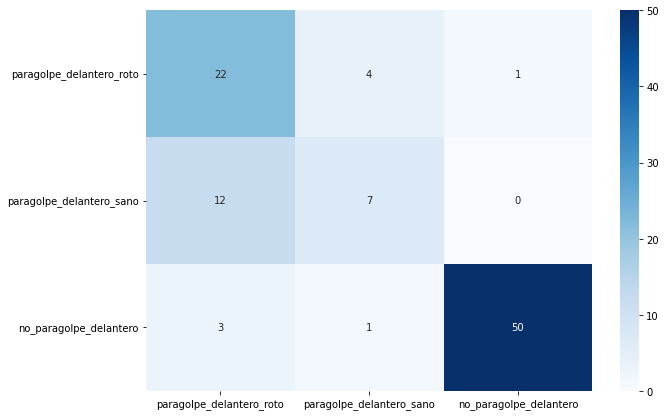

In [15]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(metrics_result['confusion_matrix'], index = classes,
                  columns = classes)

df_cm = df_cm.applymap(lambda x: x.item())

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")
df_cm.to_csv('./trained_models/{}/{}/confusion_matrix.csv'.format(MODEL_NAME, EXPERIMENT_NAME))